<h1>Binomial classification with PySpark</h1>
In this assignment you will run a streaming app in PySpark that uses the <a href="http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html?highlight=predict#pyspark.mllib.regression.StreamingLinearRegressionWithSGD">StreamingLinearRegressionWithSGD</a> and the <a href="http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html?highlight=predict#pyspark.mllib.classification.StreamingLogisticRegressionWithSGD">StreamingLogisticRegressionWithSGD</a> libraries to build prediction models on a dataset.

The dataset is available at <a href="https://drive.google.com/open?id=1KeqBf7YPykb8C4WOU4vDFS4LDJhLLGuh">https://drive.google.com/open?id=1KeqBf7YPykb8C4WOU4vDFS4LDJhLLGuh</a>

<h2>What you need to do</h2>
<li>Set up Spark streaming in a python notebook</li>
<li>Create two models, one for logistic regression and one for linear regression and parameterize them appropriately (see below)</li>
<li>Write a function that parses the data. The data header is "hour,month,weekday,Agency_Num,Borough_Num,processing_bucket"</li>
<li>The dependent variable is processing_bucket. All the other variables are in the independent feature set</li>
<li>Create two file streams. One for training data and one for testing data (see below for more explanation on the how to of the file streams)</li>
<li>Run the models. Report the following for each batch:</li>
<ol>
    <li>predictions for each model (you may report both actuals and predictions)</li>
    <li>area under roc for the logistic regression model (see BinaryClassificationMetrics)</li>
    <li>accuracy of the two models. Assume a threshold of 0.5. You will need to write a function that calculates the accuracy</li>
</ol>
<li>A plot that shows the change in roc and the two accuracy numbers over the batches. Run as many batches as you like but <b>a minimum of 10 batches is required</b>

<h2>Submission requirements</h2>
<li>The notebook with all your code</li>
<li>The run results and cell outputs must be visible in the notebook. Failure to submit a "run" notebook will cost you lots of points!</li>

<h2>Parameterizing the models</h2>
<li>You need to set two parameters: initial weights and step size</li>
<li>initial weights are the initial coefficients that the models will use. You can pretty much set these arbitrarily</li>
<li>stepsize: both models use gradient descent and the stepsize parameter is used to control how much the model should move toward the local minimum in each iteration. Setting the stepsize parameter is tricky, perhaps the hardest thing to do in ML: too high and you'll jump around without ever getting toward the minimum. Too low and the model will converge too slowly. My suggestion, set the stepsize in the linear model first:<li>
    <ul>
        <li>Set an arbitray stepsize</li>
        <li>Print the predictions at each batch time</li>
        <li>See if they are too high. If yes, lower the step size and run the model again</li>
        <li>Do this until you start getting reasonable looking predictions</li>
    </ul>
    

<h3>Managing the files</h3>
<li>the text file stream will only pickup new files in the directory so you should keep a repository of files and copy them into the train and test directories at the right time for each batch.</li>
<li>remember to delete all files if you restart the streaming context</li>
<li>my suggestion: iterate through the files (file1.csv to file10.csv) copying the same file into the train and test directories in each batch. Example, in batch 1 copy file1.csv into train and test dirs. In batch 2, copy file2.csv into train and test directories, etc. Not pure, but anything else will drive you crazy!</li>
<li>If you go beyond 10 files (not a bad idea), start again but remember not to use the same file name twice. I.e., for the 11th file, you can copy file1.csv to file11.csv</li>

<h2>General notes</h2>
<li>Remember to stop the streaming context after each run. Don't just restart the kernel or your context may still contain old functions and stream structures</li>
<li>You will need to restart the kernel each time you stop the streaming context. Organize your code so that it is easy to run the set up again</li>
<li>You may want to use a long batch interval so that you have plenty of time to copy files and get ready for the next batch. About 60 seconds should be good</li>
<li>Don't leave this till Sunday. This assignment will require a lot of trial and error!</li>
<li>Bear in mind that you're using Python, not Scala!</li>

In [1]:
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext

spark = SparkSession.builder.appName("PySpark SQL").getOrCreate()
sc = spark.sparkContext
ssc = StreamingContext(sc,60)

In [2]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.regression import StreamingLinearRegressionWithSGD

from pyspark.mllib.classification import StreamingLogisticRegressionWithSGD
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [3]:
# define the parseing function to parse the data
def parse_data(line):
    l = line.split(",")
    target = float(l[5])
    features = list(map(lambda x: float(x),l[0:5]))
    labeled_point = LabeledPoint(target,Vectors.dense(features))
    return labeled_point

# define the function to calculate the accrucy
def get_accuracy(result,pRDD):
    pred = pRDD.map(lambda x : (x[0], float(round(x[1])))).filter(lambda x: x[0]==x[1]).count()
    acc = pred/pRDD.count()
    print("the accrucy is",acc)   
    result.append(acc) 
    
# define the function to get the metrics and area under ROC for logistic model
def get_metrics_acc(result_acc,result_roc,pRDD):
    
    #calculate the accuracy
    pred = pRDD.filter(lambda x: x[0]==x[1]).count()
    acc = pred/pRDD.count()
    print("the accrucy is",acc)   
    result_acc.append(acc) 
    #calculate the area under the roc
    new_rdd = pRDD.map(lambda x : (x[0], float(round(x[1]))))
    metrics = BinaryClassificationMetrics(new_rdd)
    areunderROC = metrics.areaUnderROC
    print("the area under ROC is",areunderROC)
    result_roc.append(areunderROC)

In [4]:
training_data = ssc.textFileStream("stream_training").map(parse_data).cache()
testing_data = ssc.textFileStream("stream_testing").map(parse_data)

LINEAR REGRESSION MODEL

In [5]:

linear_model = StreamingLinearRegressionWithSGD(stepSize=0.02)
linear_model.setInitialWeights([0.0, 0.0, 0.0, 0.0, 0.0])


linear_model.trainOn(training_data)
linear_predicted_values = linear_model.predictOnValues(testing_data.map(lambda lp: (lp.label, lp.features)))
linear_predicted_values.pprint()

linear_acc = []
linear_predicted_values.foreachRDD(lambda r: get_accuracy(linear_acc,r))

In [6]:
ssc.start()

-------------------------------------------
Time: 2019-04-15 18:41:00
-------------------------------------------
(0.0, 0.0)
(0.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(1.0, 0.0)
(0.0, 0.0)
...

the accrucy is 0.4033108242869761
-------------------------------------------
Time: 2019-04-15 18:42:00
-------------------------------------------
(1.0, 0.4085958961588431)
(1.0, 0.595545554358031)
(1.0, 0.3796392546827147)
(1.0, 0.3796392546827147)
(1.0, 0.4954658205872284)
(1.0, 0.3796392546827147)
(1.0, 0.47971898845351735)
(1.0, 0.4085958961588431)
(1.0, 0.4954658205872284)
(1.0, 0.4836556964869451)
...

the accrucy is 0.5153930535373393
-------------------------------------------
Time: 2019-04-15 18:43:00
-------------------------------------------
(1.0, 0.35480672254807427)
(1.0, 0.46206573500953213)
(1.0, 0.46206573500953213)
(0.0, 0.46206573500953213)
(1.0, 0.35480672254807427)
(1.0, 0.35480672254807427)
(1.0, 0.35480672254807427)
(0.0, 0.3566185606441

In [7]:
ssc.stop()

GRAPH

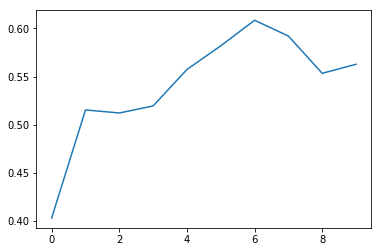

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(linear_acc)

LOGISTIC REGRESSION MODEL

In [5]:
logistic_model = StreamingLogisticRegressionWithSGD(stepSize=0.01)
logistic_model.setInitialWeights([0.0, 0.0, 0.0, 0.0, 0.0])  

logistic_model.trainOn(training_data)
logistic_predicted_values = logistic_model.predictOnValues(testing_data.map(lambda lp: (lp.label, lp.features)))
logistic_predicted_values.pprint()

logistic_acc = []
logistic_roc = []
logistic_predicted_values.foreachRDD(lambda r: get_metrics_acc(logistic_acc,logistic_roc,r))

ssc.start()

In [7]:
ssc.stop()

GRAPH

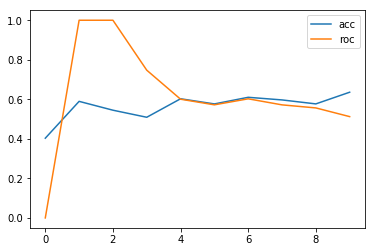

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(logistic_acc,label = "acc")
plt.plot(logistic_roc,label = "roc")
plt.legend()